# Advanced Uplift Model Evaluation

This notebook covers advanced evaluation techniques for uplift models:

1. **Uplift by Decile Analysis** - Granular view of model performance across population segments
2. **Calibration Plot for Uplift** - Are predicted uplifts well-calibrated?
3. **Statistical Significance Testing** - Bootstrap hypothesis tests to compare models

These go beyond basic metrics (Qini, AUUC) to provide actionable business insights and statistical rigor.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

%matplotlib inline

print("✅ Libraries loaded successfully!")
print("📁 This notebook loads saved model predictions from notebook 02")


✅ Libraries loaded successfully!
📁 This notebook loads saved model predictions from notebook 02


## 1. Load Saved Model Predictions

**No retraining needed!** We load pre-computed predictions from notebook 02's saved artifacts.


In [ ]:
# No need to load raw data - we use saved predictions!
# This saves time and ensures consistency across notebooks

print("ℹ️ Skipping raw data loading...")
print("   Predictions will be loaded from: visualizations/data/nb02_predictions.csv")


ℹ️ Skipping raw data loading...
   Predictions will be loaded from: visualizations/data/nb02_predictions.csv


In [ ]:
# Load saved predictions from Notebook 02 (no need to retrain!)
print("Loading saved predictions from notebook 02...")

from pathlib import Path
viz_data_dir = Path('..') / 'visualizations' / 'data'

# Check if predictions file exists
predictions_file = viz_data_dir / 'nb02_predictions.csv'

if predictions_file.exists():
    # Load pre-computed predictions
    saved_preds = pd.read_csv(predictions_file)
    
    y_test = saved_preds['y_true'].values
    t_test = saved_preds['treatment'].values
    uplift_t = saved_preds['uplift_t_learner'].values
    uplift_s = saved_preds['uplift_s_learner'].values
    uplift_x = saved_preds['uplift_x_learner'].values
    
    print("✅ Loaded T-Learner predictions")
    print("✅ Loaded S-Learner predictions")
    print("✅ Loaded X-Learner predictions")
    print(f"\nLoaded {len(y_test):,} test samples from saved artifacts")
else:
    raise FileNotFoundError(
        f"Predictions file not found: {predictions_file}\n"
        "Please run notebook 02 first to generate model artifacts."
    )

# Store predictions for evaluation
models = {
    'T-Learner': uplift_t,
    'S-Learner': uplift_s,
    'X-Learner': uplift_x
}


Loading saved predictions from notebook 02...
✅ Loaded T-Learner predictions
✅ Loaded S-Learner predictions
✅ Loaded X-Learner predictions

Loaded 90,000 test samples from saved artifacts


## 2. Uplift by Decile Analysis

**Why Decile Analysis?**
- More granular than overall metrics
- Shows uplift in each 10% segment of population
- Answers: "If I target top 30%, what uplift do I get in each decile?"
- Reveals if model truly separates Persuadables from others

**Columns Explained:**
- **Decile**: Population segment ranked by predicted uplift (1 = highest predicted)
- **Avg Predicted Uplift**: Mean predicted CATE in that decile
- **Actual Uplift**: Observed uplift (treatment conv rate - control conv rate)
- **Lift vs Random**: How much better than random targeting?


In [ ]:
def uplift_by_decile(y_true, uplift_pred, treatment, n_deciles=10):
    """
    Calculate uplift metrics by decile.
    
    Returns DataFrame with:
    - Decile (1 = highest predicted uplift)
    - Avg Predicted Uplift
    - Actual Uplift (treatment effect in that decile)
    - Sample sizes
    - Lift vs Random
    """
    # Create DataFrame
    df = pd.DataFrame({
        'y': y_true,
        'uplift_pred': uplift_pred,
        'treatment': treatment
    })
    
    # Rank by predicted uplift (descending) and assign deciles
    df['decile'] = pd.qcut(df['uplift_pred'].rank(method='first'), 
                           q=n_deciles, labels=False)
    df['decile'] = n_deciles - df['decile']  # So decile 1 = highest uplift
    
    # Calculate overall (random) uplift
    overall_uplift = (df[df['treatment']==1]['y'].mean() - 
                      df[df['treatment']==0]['y'].mean())
    
    results = []
    for decile in range(1, n_deciles + 1):
        subset = df[df['decile'] == decile]
        
        treated = subset[subset['treatment'] == 1]
        control = subset[subset['treatment'] == 0]
        
        avg_pred_uplift = subset['uplift_pred'].mean()
        
        if len(treated) > 0 and len(control) > 0:
            actual_uplift = treated['y'].mean() - control['y'].mean()
        else:
            actual_uplift = np.nan
            
        lift_vs_random = actual_uplift / overall_uplift if overall_uplift != 0 else np.nan
        
        results.append({
            'Decile': decile,
            'N': len(subset),
            'N_Treated': len(treated),
            'N_Control': len(control),
            'Avg Predicted Uplift (%)': avg_pred_uplift * 100,
            'Actual Uplift (%)': actual_uplift * 100,
            'Lift vs Random': lift_vs_random
        })
    
    return pd.DataFrame(results)

print("✅ Decile analysis function defined")


✅ Decile analysis function defined


In [ ]:
# Calculate decile analysis for each model
print("=" * 80)
print("UPLIFT BY DECILE ANALYSIS")
print("=" * 80)

for model_name, uplift_pred in models.items():
    print(f"\n{'='*40}")
    print(f"📊 {model_name}")
    print(f"{'='*40}")
    
    decile_df = uplift_by_decile(y_test, uplift_pred, t_test)
    
    # Format for display
    display_df = decile_df.copy()
    display_df['Avg Predicted Uplift (%)'] = display_df['Avg Predicted Uplift (%)'].round(4)
    display_df['Actual Uplift (%)'] = display_df['Actual Uplift (%)'].round(4)
    display_df['Lift vs Random'] = display_df['Lift vs Random'].round(2)
    
    print(display_df.to_string(index=False))
    
    # Key insight
    top_decile_lift = decile_df.iloc[0]['Lift vs Random']
    print(f"\n💡 Top decile delivers {top_decile_lift:.1f}x the uplift of random targeting")


UPLIFT BY DECILE ANALYSIS

📊 T-Learner
 Decile    N  N_Treated  N_Control  Avg Predicted Uplift (%)  Actual Uplift (%)  Lift vs Random
      1 9000       7740       1260                    1.8633             0.8140            7.13
      2 9000       7639       1361                    0.1185             0.1360            1.19
      3 9000       7685       1315                    0.0498             0.0390            0.34
      4 9000       7593       1407                    0.0227            -0.0447           -0.39
      5 9000       7614       1386                    0.0105            -0.0722           -0.63
      6 9000       7662       1338                    0.0024             0.0000            0.00
      7 9000       7646       1354                    0.0013             0.0000            0.00
      8 9000       7623       1377                   -0.0000             0.0394            0.34
      9 9000       7671       1329                   -0.0012            -0.0752           -0.66
 

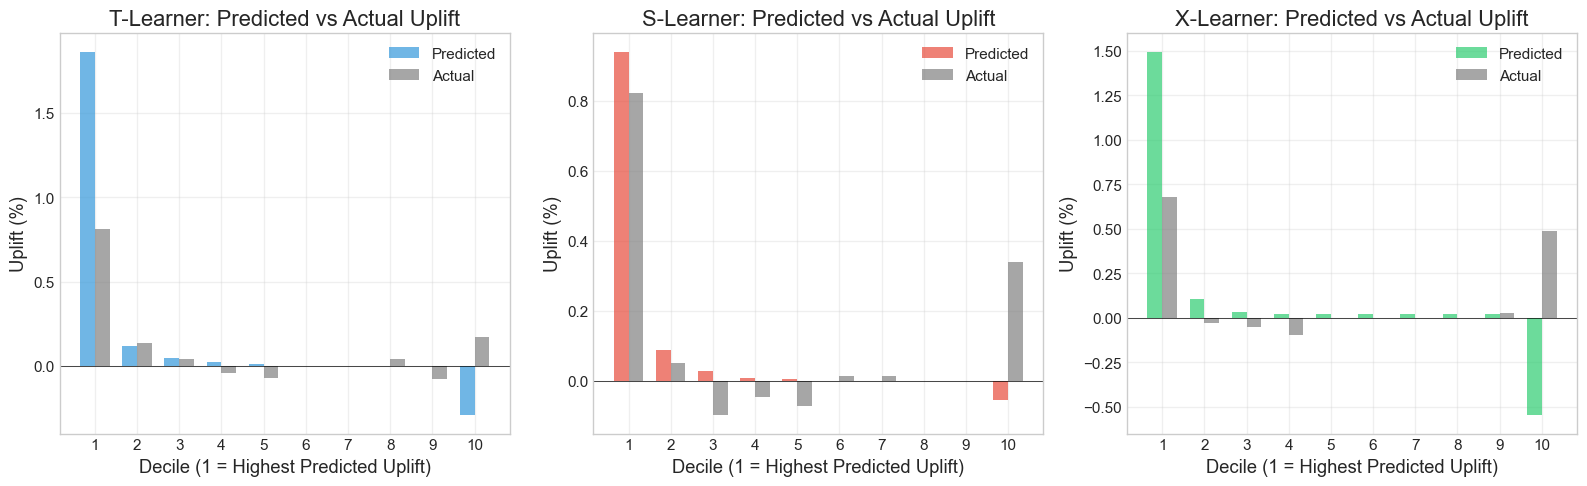

In [ ]:
# Visualize decile analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = {'T-Learner': '#3498db', 'S-Learner': '#e74c3c', 'X-Learner': '#2ecc71'}

for ax, (model_name, uplift_pred) in zip(axes, models.items()):
    decile_df = uplift_by_decile(y_test, uplift_pred, t_test)
    
    x = decile_df['Decile']
    
    # Bar chart: Predicted vs Actual
    width = 0.35
    ax.bar(x - width/2, decile_df['Avg Predicted Uplift (%)'], width, 
           label='Predicted', color=colors[model_name], alpha=0.7)
    ax.bar(x + width/2, decile_df['Actual Uplift (%)'], width,
           label='Actual', color='gray', alpha=0.7)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Decile (1 = Highest Predicted Uplift)')
    ax.set_ylabel('Uplift (%)')
    ax.set_title(f'{model_name}: Predicted vs Actual Uplift')
    ax.set_xticks(x)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


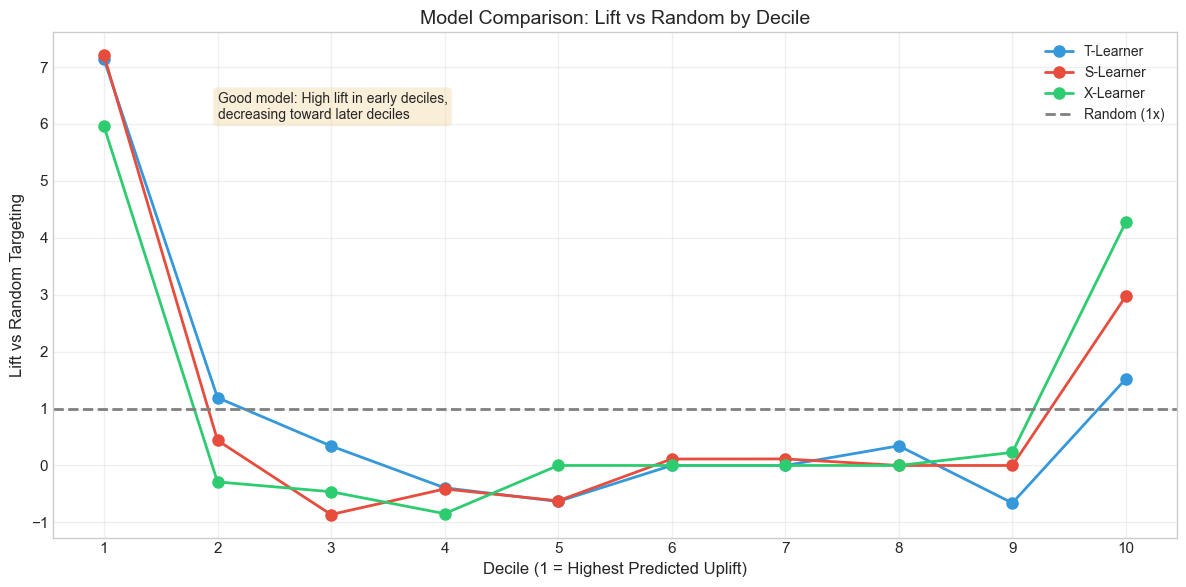

In [ ]:
# Compare all models: Lift vs Random by Decile
fig, ax = plt.subplots(figsize=(12, 6))

for model_name, uplift_pred in models.items():
    decile_df = uplift_by_decile(y_test, uplift_pred, t_test)
    ax.plot(decile_df['Decile'], decile_df['Lift vs Random'], 
            marker='o', linewidth=2, markersize=8, label=model_name, color=colors[model_name])

ax.axhline(y=1, color='gray', linestyle='--', linewidth=2, label='Random (1x)')
ax.set_xlabel('Decile (1 = Highest Predicted Uplift)', fontsize=12)
ax.set_ylabel('Lift vs Random Targeting', fontsize=12)
ax.set_title('Model Comparison: Lift vs Random by Decile', fontsize=14)
ax.set_xticks(range(1, 11))
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Highlight interpretation
ax.annotate('Good model: High lift in early deciles,\ndecreasing toward later deciles', 
            xy=(2, ax.get_ylim()[1] * 0.8), fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


## 3. Calibration Plot for Uplift

**What is Uplift Calibration?**
- A well-calibrated model: when it predicts 0.5% uplift, the actual uplift should be ~0.5%
- If predicted 1% → actual 2%, the model is **under-confident** (underestimates true effect)
- If predicted 1% → actual 0.5%, the model is **over-confident** (overestimates)

**Why it matters:**
- For budget allocation: if model says "this segment has 2% uplift", we need that to be accurate
- Poorly calibrated models lead to wrong ROI calculations

**Reading the plot:**
- Perfect calibration = points on the diagonal line
- Above diagonal = model under-predicts (actual > predicted)
- Below diagonal = model over-predicts (actual < predicted)


In [ ]:
def uplift_calibration(y_true, uplift_pred, treatment, n_bins=10):
    """
    Calculate calibration data for uplift predictions.
    
    Groups predictions into bins and compares mean predicted vs actual uplift.
    """
    df = pd.DataFrame({
        'y': y_true,
        'uplift_pred': uplift_pred,
        'treatment': treatment
    })
    
    # Bin by predicted uplift
    df['bin'] = pd.qcut(df['uplift_pred'], q=n_bins, labels=False, duplicates='drop')
    
    results = []
    for bin_idx in sorted(df['bin'].unique()):
        subset = df[df['bin'] == bin_idx]
        
        treated = subset[subset['treatment'] == 1]
        control = subset[subset['treatment'] == 0]
        
        mean_pred = subset['uplift_pred'].mean()
        
        if len(treated) > 0 and len(control) > 0:
            actual_uplift = treated['y'].mean() - control['y'].mean()
        else:
            actual_uplift = np.nan
            
        results.append({
            'bin': bin_idx + 1,
            'mean_predicted': mean_pred,
            'actual_uplift': actual_uplift,
            'n_samples': len(subset)
        })
    
    return pd.DataFrame(results)

print("✅ Calibration function defined")


✅ Calibration function defined


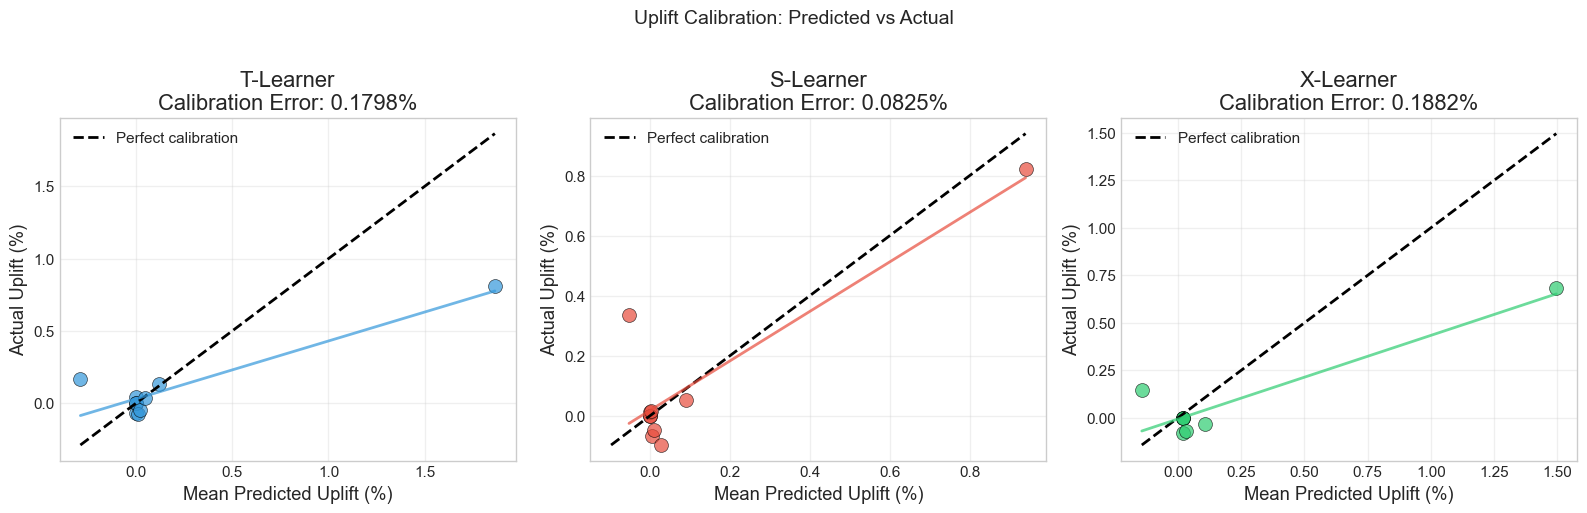


📊 Calibration Error Summary (lower = better calibrated):
  S-Learner: 0.0825%
  T-Learner: 0.1798%
  X-Learner: 0.1882%


In [ ]:
# Calculate and plot calibration for each model
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

calibration_metrics = {}

for ax, (model_name, uplift_pred) in zip(axes, models.items()):
    cal_df = uplift_calibration(y_test, uplift_pred, t_test, n_bins=10)
    
    # Convert to percentage for readability
    pred_pct = cal_df['mean_predicted'] * 100
    actual_pct = cal_df['actual_uplift'] * 100
    
    # Scatter plot
    ax.scatter(pred_pct, actual_pct, s=100, c=colors[model_name], alpha=0.7, edgecolors='black')
    
    # Perfect calibration line
    min_val = min(pred_pct.min(), actual_pct.min())
    max_val = max(pred_pct.max(), actual_pct.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect calibration')
    
    # Calculate calibration error (Mean Absolute Error)
    cal_error = np.abs(pred_pct - actual_pct).mean()
    calibration_metrics[model_name] = cal_error
    
    ax.set_xlabel('Mean Predicted Uplift (%)')
    ax.set_ylabel('Actual Uplift (%)')
    ax.set_title(f'{model_name}\nCalibration Error: {cal_error:.4f}%')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add regression line
    z = np.polyfit(pred_pct, actual_pct, 1)
    p = np.poly1d(z)
    ax.plot(pred_pct.sort_values(), p(pred_pct.sort_values()), 
            color=colors[model_name], linestyle='-', linewidth=2, alpha=0.7)

plt.suptitle('Uplift Calibration: Predicted vs Actual', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Summary
print("\n📊 Calibration Error Summary (lower = better calibrated):")
for model, error in sorted(calibration_metrics.items(), key=lambda x: x[1]):
    print(f"  {model}: {error:.4f}%")


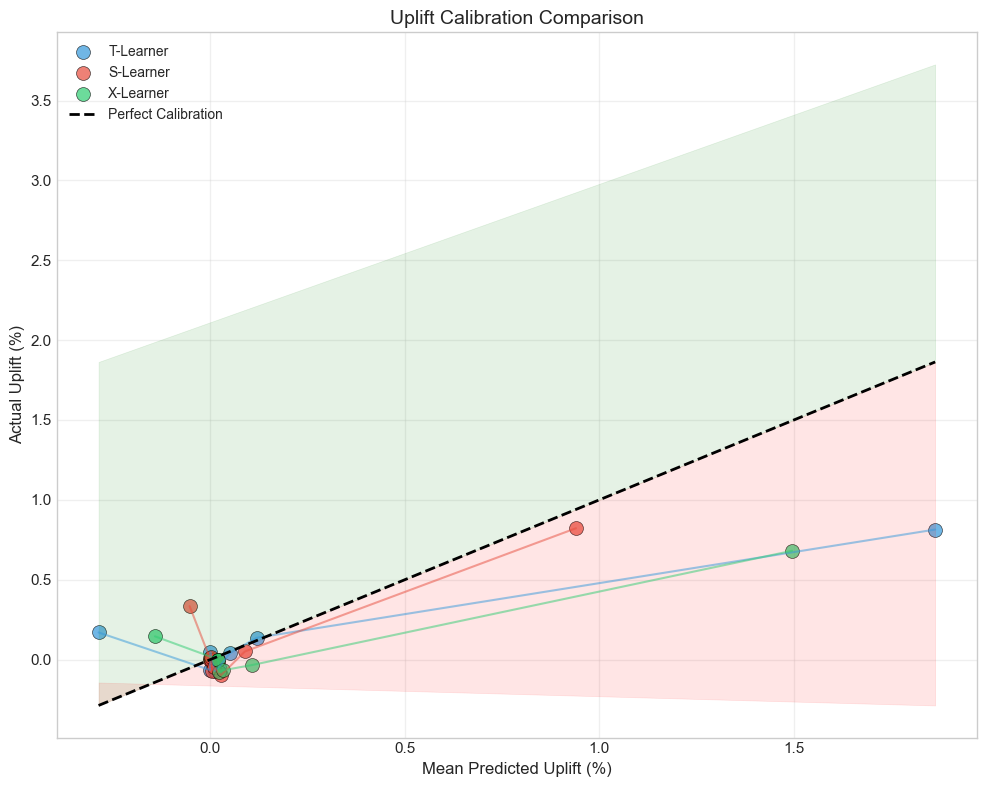

In [ ]:
# Combined calibration plot
fig, ax = plt.subplots(figsize=(10, 8))

for model_name, uplift_pred in models.items():
    cal_df = uplift_calibration(y_test, uplift_pred, t_test, n_bins=10)
    pred_pct = cal_df['mean_predicted'] * 100
    actual_pct = cal_df['actual_uplift'] * 100
    
    ax.scatter(pred_pct, actual_pct, s=100, c=colors[model_name], alpha=0.7, 
               edgecolors='black', label=model_name)
    
    # Connect points with lines
    sorted_idx = pred_pct.argsort()
    ax.plot(pred_pct.iloc[sorted_idx], actual_pct.iloc[sorted_idx], 
            color=colors[model_name], alpha=0.5, linewidth=1.5)

# Perfect calibration line
all_vals = []
for uplift_pred in models.values():
    cal_df = uplift_calibration(y_test, uplift_pred, t_test, n_bins=10)
    all_vals.extend(cal_df['mean_predicted'] * 100)
    all_vals.extend(cal_df['actual_uplift'] * 100)

min_val, max_val = min(all_vals), max(all_vals)
ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Calibration')

ax.set_xlabel('Mean Predicted Uplift (%)', fontsize=12)
ax.set_ylabel('Actual Uplift (%)', fontsize=12)
ax.set_title('Uplift Calibration Comparison', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Add interpretation zone
ax.fill_between([min_val, max_val], [min_val, max_val], [max_val, max_val*2], 
                alpha=0.1, color='green', label='_Under-predicting')
ax.fill_between([min_val, max_val], [min_val*0.5, min_val], [min_val, max_val], 
                alpha=0.1, color='red', label='_Over-predicting')

plt.tight_layout()
plt.show()


## 4. Statistical Significance Testing

**The Question:** Is T-Learner *significantly* better than X-Learner, or could the difference be due to random chance?

**Approach: Bootstrap Hypothesis Testing**
1. Resample the test set with replacement (B times)
2. Calculate Qini coefficient for each model on each bootstrap sample
3. Compute the difference (T-Learner Qini - X-Learner Qini) for each sample
4. If 95% CI of difference excludes 0 → statistically significant

**Interpretation:**
- p-value < 0.05: Difference is statistically significant
- 95% CI doesn't include 0: One model is significantly better


In [ ]:
def calc_qini_coefficient(y_true, uplift_pred, treatment, n_bins=100):
    """Calculate Qini coefficient (area between model and random Qini curves)."""
    df = pd.DataFrame({
        'y': y_true, 
        'uplift': uplift_pred, 
        'treatment': treatment
    })
    df = df.sort_values('uplift', ascending=False).reset_index(drop=True)
    
    n = len(df)
    qini_values = []
    
    for i in range(1, n_bins + 1):
        k = int(n * i / n_bins)
        subset = df.iloc[:k]
        
        treated = subset[subset['treatment'] == 1]
        control = subset[subset['treatment'] == 0]
        
        if len(treated) > 0 and len(control) > 0:
            uplift = treated['y'].mean() - control['y'].mean()
            qini = uplift * k
        else:
            qini = 0
            
        qini_values.append(qini)
    
    # Area under model's Qini curve
    percentiles = np.linspace(0.01, 1, n_bins)
    model_area = np.trapz(qini_values, percentiles)
    
    # Area under random Qini curve (triangle)
    final_qini = qini_values[-1]
    random_area = 0.5 * final_qini
    
    return model_area - random_area

print("✅ Qini coefficient function defined")


✅ Qini coefficient function defined


In [ ]:
def bootstrap_qini_comparison(y_true, uplift_a, uplift_b, treatment, 
                               n_bootstrap=1000, confidence_level=0.95):
    """
    Bootstrap hypothesis test comparing two uplift models' Qini coefficients.
    
    Returns:
    - diff_mean: Mean difference (A - B)
    - diff_ci: Confidence interval for the difference
    - p_value: Two-sided p-value for H0: no difference
    """
    n = len(y_true)
    diff_scores = []
    
    np.random.seed(42)
    
    for i in range(n_bootstrap):
        # Bootstrap sample (with replacement)
        idx = np.random.choice(n, size=n, replace=True)
        
        y_boot = y_true[idx]
        uplift_a_boot = uplift_a[idx]
        uplift_b_boot = uplift_b[idx]
        t_boot = treatment[idx]
        
        # Calculate Qini for each model
        qini_a = calc_qini_coefficient(y_boot, uplift_a_boot, t_boot)
        qini_b = calc_qini_coefficient(y_boot, uplift_b_boot, t_boot)
        
        diff_scores.append(qini_a - qini_b)
        
        if (i + 1) % 200 == 0:
            print(f"  Bootstrap iteration {i+1}/{n_bootstrap}")
    
    diff_scores = np.array(diff_scores)
    
    # Statistics
    diff_mean = diff_scores.mean()
    diff_std = diff_scores.std()
    
    # Confidence interval
    alpha = 1 - confidence_level
    ci_lower = np.percentile(diff_scores, alpha/2 * 100)
    ci_upper = np.percentile(diff_scores, (1 - alpha/2) * 100)
    
    # P-value (two-sided): proportion of bootstrap samples where diff <= 0 (if mean > 0)
    # or diff >= 0 (if mean < 0)
    if diff_mean > 0:
        p_value = 2 * (diff_scores <= 0).mean()
    else:
        p_value = 2 * (diff_scores >= 0).mean()
    p_value = min(p_value, 1.0)  # Cap at 1
    
    return {
        'diff_mean': diff_mean,
        'diff_std': diff_std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': p_value,
        'diff_scores': diff_scores
    }

print("✅ Bootstrap comparison function defined")


✅ Bootstrap comparison function defined


In [ ]:
# Run bootstrap comparison: T-Learner vs X-Learner
print("=" * 60)
print("BOOTSTRAP HYPOTHESIS TEST: T-Learner vs X-Learner")
print("=" * 60)
print("\nH0: No difference in Qini coefficient between models")
print("H1: T-Learner has higher Qini coefficient than X-Learner")
print("\nRunning 500 bootstrap iterations...")

result_tx = bootstrap_qini_comparison(
    y_test, uplift_t, uplift_x, t_test, 
    n_bootstrap=500, confidence_level=0.95
)

print(f"\n{'='*60}")
print("RESULTS: T-Learner vs X-Learner")
print(f"{'='*60}")
print(f"Mean Qini Difference (T - X): {result_tx['diff_mean']:.4f}")
print(f"Standard Error: {result_tx['diff_std']:.4f}")
print(f"95% Confidence Interval: [{result_tx['ci_lower']:.4f}, {result_tx['ci_upper']:.4f}]")
print(f"P-value: {result_tx['p_value']:.4f}")

if result_tx['p_value'] < 0.05:
    print(f"\n✅ SIGNIFICANT at α=0.05: T-Learner is statistically better than X-Learner")
else:
    print(f"\n⚠️ NOT significant at α=0.05: Cannot conclude T-Learner is better")


BOOTSTRAP HYPOTHESIS TEST: T-Learner vs X-Learner

H0: No difference in Qini coefficient between models
H1: T-Learner has higher Qini coefficient than X-Learner

Running 500 bootstrap iterations...
  Bootstrap iteration 200/500
  Bootstrap iteration 400/500

RESULTS: T-Learner vs X-Learner
Mean Qini Difference (T - X): 28.9707
Standard Error: 19.1131
95% Confidence Interval: [-10.3218, 66.8727]
P-value: 0.1280

⚠️ NOT significant at α=0.05: Cannot conclude T-Learner is better


In [ ]:
# Run bootstrap comparison: T-Learner vs S-Learner
print("\n" + "=" * 60)
print("BOOTSTRAP HYPOTHESIS TEST: T-Learner vs S-Learner")
print("=" * 60)
print("\nRunning 500 bootstrap iterations...")

result_ts = bootstrap_qini_comparison(
    y_test, uplift_t, uplift_s, t_test, 
    n_bootstrap=500, confidence_level=0.95
)

print(f"\n{'='*60}")
print("RESULTS: T-Learner vs S-Learner")
print(f"{'='*60}")
print(f"Mean Qini Difference (T - S): {result_ts['diff_mean']:.4f}")
print(f"Standard Error: {result_ts['diff_std']:.4f}")
print(f"95% Confidence Interval: [{result_ts['ci_lower']:.4f}, {result_ts['ci_upper']:.4f}]")
print(f"P-value: {result_ts['p_value']:.4f}")

if result_ts['p_value'] < 0.05:
    print(f"\n✅ SIGNIFICANT at α=0.05: T-Learner is statistically better than S-Learner")
else:
    print(f"\n⚠️ NOT significant at α=0.05: Cannot conclude T-Learner is better")



BOOTSTRAP HYPOTHESIS TEST: T-Learner vs S-Learner

Running 500 bootstrap iterations...
  Bootstrap iteration 200/500
  Bootstrap iteration 400/500

RESULTS: T-Learner vs S-Learner
Mean Qini Difference (T - S): 15.3247
Standard Error: 13.8327
95% Confidence Interval: [-9.2625, 44.8184]
P-value: 0.2960

⚠️ NOT significant at α=0.05: Cannot conclude T-Learner is better


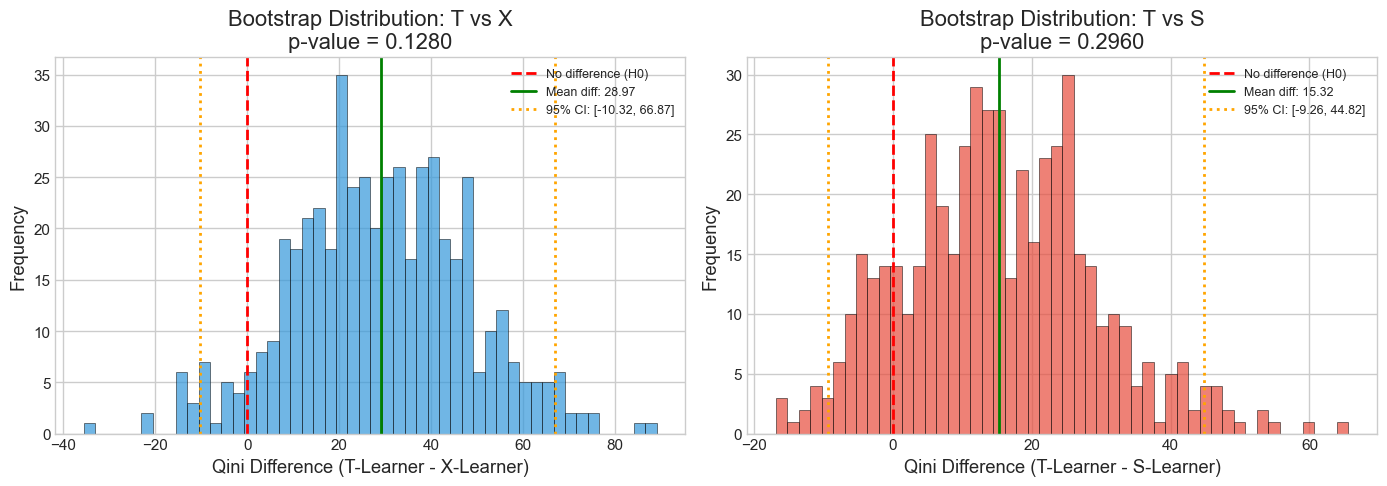

In [ ]:
# Visualize bootstrap distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# T-Learner vs X-Learner
ax1 = axes[0]
ax1.hist(result_tx['diff_scores'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference (H0)')
ax1.axvline(x=result_tx['diff_mean'], color='green', linestyle='-', linewidth=2, 
            label=f'Mean diff: {result_tx["diff_mean"]:.2f}')
ax1.axvline(x=result_tx['ci_lower'], color='orange', linestyle=':', linewidth=2)
ax1.axvline(x=result_tx['ci_upper'], color='orange', linestyle=':', linewidth=2, 
            label=f'95% CI: [{result_tx["ci_lower"]:.2f}, {result_tx["ci_upper"]:.2f}]')
ax1.set_xlabel('Qini Difference (T-Learner - X-Learner)')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Bootstrap Distribution: T vs X\np-value = {result_tx["p_value"]:.4f}')
ax1.legend(fontsize=9)

# T-Learner vs S-Learner
ax2 = axes[1]
ax2.hist(result_ts['diff_scores'], bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference (H0)')
ax2.axvline(x=result_ts['diff_mean'], color='green', linestyle='-', linewidth=2,
            label=f'Mean diff: {result_ts["diff_mean"]:.2f}')
ax2.axvline(x=result_ts['ci_lower'], color='orange', linestyle=':', linewidth=2)
ax2.axvline(x=result_ts['ci_upper'], color='orange', linestyle=':', linewidth=2,
            label=f'95% CI: [{result_ts["ci_lower"]:.2f}, {result_ts["ci_upper"]:.2f}]')
ax2.set_xlabel('Qini Difference (T-Learner - S-Learner)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Bootstrap Distribution: T vs S\np-value = {result_ts["p_value"]:.4f}')
ax2.legend(fontsize=9)

plt.tight_layout()
plt.show()


## 5. Summary & Key Takeaways

### Advanced Evaluation Methods Covered:

| Method | Purpose | Key Insight |
|--------|---------|-------------|
| **Decile Analysis** | Granular performance view | See uplift in each population segment |
| **Calibration Plot** | Check prediction accuracy | Is predicted uplift reliable for ROI calculations? |
| **Bootstrap Testing** | Statistical significance | Is model A *significantly* better than B? |

### Business Implications:

1. **Decile Analysis**: 
   - Target only the top deciles where uplift is highest
   - Avoid bottom deciles which may have negative uplift (Sleeping Dogs)

2. **Calibration**:
   - Well-calibrated models enable accurate ROI projections
   - Poorly calibrated → misleading budget allocations

3. **Statistical Significance**:
   - Don't deploy a new model just because Qini is slightly higher
   - Require statistical significance to justify implementation costs

### Recommended Workflow:

```
1. Train multiple uplift models
2. Compare with basic metrics (Qini, AUUC)
3. Dive deeper with decile analysis
4. Check calibration for deployment readiness
5. Run bootstrap tests before finalizing model choice
6. Deploy winner, monitor in production
```


---

## 🚀 Production Pipeline: Save Artifacts

Save evaluation results and visualizations for Streamlit dashboard.


In [ ]:
import joblib
from pathlib import Path

# Create directories
project_root = Path('..').resolve()
models_dir = project_root / 'models'
viz_images_dir = project_root / 'visualizations' / 'images'
viz_data_dir = project_root / 'visualizations' / 'data'

for dir_path in [models_dir, viz_images_dir, viz_data_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("Directories ready for saving artifacts")


Directories ready for saving artifacts


In [ ]:
# Save decile analysis data for all models
print("Saving decile analysis data...")

decile_data_list = []
for model_name, uplift_pred in models.items():
    decile_df = uplift_by_decile(y_test, uplift_pred, t_test)
    decile_df['Model'] = model_name
    decile_data_list.append(decile_df)

all_deciles_df = pd.concat(decile_data_list, ignore_index=True)
all_deciles_df.to_csv(viz_data_dir / 'nb04_decile_analysis.csv', index=False)
print(f"✅ Decile analysis saved: nb04_decile_analysis.csv")


Saving decile analysis data...
✅ Decile analysis saved: nb04_decile_analysis.csv


In [ ]:
# Save calibration data
print("Saving calibration data...")

calibration_data_list = []
for model_name, uplift_pred in models.items():
    cal_df = uplift_calibration(y_test, uplift_pred, t_test, n_bins=10)
    cal_df['Model'] = model_name
    calibration_data_list.append(cal_df)

all_calibration_df = pd.concat(calibration_data_list, ignore_index=True)
all_calibration_df.to_csv(viz_data_dir / 'nb04_calibration_data.csv', index=False)
print(f"✅ Calibration data saved: nb04_calibration_data.csv")


Saving calibration data...
✅ Calibration data saved: nb04_calibration_data.csv


In [ ]:
# Save bootstrap test results
print("Saving bootstrap test results...")

bootstrap_results = pd.DataFrame({
    'Comparison': ['T-Learner vs X-Learner', 'T-Learner vs S-Learner'],
    'Mean_Difference': [result_tx['diff_mean'], result_ts['diff_mean']],
    'Std_Error': [result_tx['diff_std'], result_ts['diff_std']],
    'CI_Lower': [result_tx['ci_lower'], result_ts['ci_lower']],
    'CI_Upper': [result_tx['ci_upper'], result_ts['ci_upper']],
    'P_Value': [result_tx['p_value'], result_ts['p_value']],
    'Significant': [result_tx['p_value'] < 0.05, result_ts['p_value'] < 0.05]
})

bootstrap_results.to_csv(viz_data_dir / 'nb04_bootstrap_results.csv', index=False)
print(f"✅ Bootstrap results saved: nb04_bootstrap_results.csv")
bootstrap_results


Saving bootstrap test results...
✅ Bootstrap results saved: nb04_bootstrap_results.csv


,Comparison,Mean_Difference,Std_Error,CI_Lower,CI_Upper,P_Value,Significant
0,T-Learner vs X-Learner,28.970695,19.113096,-10.321764,66.872731,0.128,False
1,T-Learner vs S-Learner,15.324705,13.832694,-9.262497,44.818440,0.296,False


In [ ]:
# Save visualization images
print("Saving visualization images...")
colors = {'T-Learner': '#3498db', 'S-Learner': '#e74c3c', 'X-Learner': '#2ecc71'}

# 1. Decile Analysis - Lift vs Random
fig, ax = plt.subplots(figsize=(12, 6))

for model_name, uplift_pred in models.items():
    decile_df = uplift_by_decile(y_test, uplift_pred, t_test)
    ax.plot(decile_df['Decile'], decile_df['Lift vs Random'], 
            marker='o', linewidth=2, markersize=8, label=model_name, color=colors[model_name])

ax.axhline(y=1, color='gray', linestyle='--', linewidth=2, label='Random (1x)')
ax.set_xlabel('Decile (1 = Highest Predicted Uplift)')
ax.set_ylabel('Lift vs Random Targeting')
ax.set_title('Model Comparison: Lift vs Random by Decile')
ax.set_xticks(range(1, 11))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(viz_images_dir / 'nb04_decile_lift.png', dpi=150, bbox_inches='tight')
plt.close()
print(f"✅ Saved: nb04_decile_lift.png")


Saving visualization images...
✅ Saved: nb04_decile_lift.png


In [ ]:
# 2. Calibration Plot
fig, ax = plt.subplots(figsize=(10, 8))

for model_name, uplift_pred in models.items():
    cal_df = uplift_calibration(y_test, uplift_pred, t_test, n_bins=10)
    pred_pct = cal_df['mean_predicted'] * 100
    actual_pct = cal_df['actual_uplift'] * 100
    
    ax.scatter(pred_pct, actual_pct, s=100, c=colors[model_name], alpha=0.7, 
               edgecolors='black', label=model_name)
    sorted_idx = pred_pct.argsort()
    ax.plot(pred_pct.iloc[sorted_idx], actual_pct.iloc[sorted_idx], 
            color=colors[model_name], alpha=0.5, linewidth=1.5)

# Perfect calibration line
all_vals = []
for uplift_pred in models.values():
    cal_df = uplift_calibration(y_test, uplift_pred, t_test, n_bins=10)
    all_vals.extend(cal_df['mean_predicted'] * 100)
    all_vals.extend(cal_df['actual_uplift'] * 100)

min_val, max_val = min(all_vals), max(all_vals)
ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Calibration')

ax.set_xlabel('Mean Predicted Uplift (%)')
ax.set_ylabel('Actual Uplift (%)')
ax.set_title('Uplift Calibration Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(viz_images_dir / 'nb04_calibration.png', dpi=150, bbox_inches='tight')
plt.close()
print(f"✅ Saved: nb04_calibration.png")


✅ Saved: nb04_calibration.png


In [ ]:
# 3. Bootstrap Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# T-Learner vs X-Learner
ax1 = axes[0]
ax1.hist(result_tx['diff_scores'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference (H0)')
ax1.axvline(x=result_tx['diff_mean'], color='green', linestyle='-', linewidth=2, 
            label=f'Mean diff: {result_tx["diff_mean"]:.2f}')
ax1.set_xlabel('Qini Difference (T-Learner - X-Learner)')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Bootstrap: T vs X\np-value = {result_tx["p_value"]:.4f}')
ax1.legend(fontsize=9)

# T-Learner vs S-Learner
ax2 = axes[1]
ax2.hist(result_ts['diff_scores'], bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference (H0)')
ax2.axvline(x=result_ts['diff_mean'], color='green', linestyle='-', linewidth=2,
            label=f'Mean diff: {result_ts["diff_mean"]:.2f}')
ax2.set_xlabel('Qini Difference (T-Learner - S-Learner)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Bootstrap: T vs S\np-value = {result_ts["p_value"]:.4f}')
ax2.legend(fontsize=9)

plt.tight_layout()
plt.savefig(viz_images_dir / 'nb04_bootstrap_distributions.png', dpi=150, bbox_inches='tight')
plt.close()
print(f"✅ Saved: nb04_bootstrap_distributions.png")

print("\n" + "="*60)
print("✅ ALL NOTEBOOK 04 ARTIFACTS SAVED SUCCESSFULLY!")
print("="*60)


✅ Saved: nb04_bootstrap_distributions.png

✅ ALL NOTEBOOK 04 ARTIFACTS SAVED SUCCESSFULLY!
